## **Zillow**
## Web scraping & House Price Prediction using Tensor Flow 
---
## Group Assignment
---
### ALY6040_Winter2021_TermA_Assignment-4
---
**Instructor:** Fidel Rodriguez 

**Course:** ALY6040 Data Mining

**Group -** 1

**Team Members -** 

*   Pragati Koladiya
*   Munitha Priyanka Kanukollu
*   Tanvi Bhagat
*   Ketaki Joshi



## Required packages and dependencies

In [1]:
!pip install htmltext
!pip install prettify 
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!sudo apt install libmysqlclient-dev
!pip install mysql
!pip install mysql-connector-python-rf
!pip install -q seaborn

  Created wheel for prettify: filename=prettify-0.1.1-cp37-none-any.whl size=8425 sha256=e4247450ae75f8abc2e06299f1f6688c9e33ca35813642a26181f127b6bd89de
  Stored in directory: /root/.cache/pip/wheels/49/44/c3/f997cb138383a4a0399a6b2f75012746c533a24ff6b02fafe0
Successfully built prettify
     |████████████████████████████████| 911kB 5.6MB/s 
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive

## Importing required libraries

In [2]:
import mysql.connector
import time
import subprocess
import os
import pytz
import os
import math
import time
import sys
import numpy as np
import pandas as pd
import regex as re
import requests
import lxml
import tensorflow as tf
import prettify
import numbers
import htmltext
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
from bs4 import BeautifulSoup
from datetime import datetime, date
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from pytz import timezone
from selenium.webdriver.common.by import By
from lxml.html.soupparser import fromstring
from random import randint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


## Assigning request header 

In [3]:
#Display settings for notebook
pd.set_option('display.max_rows', 50000000)
pd.set_option('display.max_colwidth',10000000)
pd.set_option('display.max_columns', 50000000)
pd.set_option('display.width', 100000000)

#add headers in case you use chromedriver (captchas are no fun); namely used for chromedriver
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

#Database Environment setup

In [4]:
def establish_database_connection(attempts = 0):
  if attempts >4:
    print("Error in establishing connection...  tried 5 times now quitting")
    return -1
  else:
    try:
     cnx = mysql.connector.connect(user='root4', password='!GoodPassword123!',
                                    host='34.67.144.96',
                                    port=3306,
                                    database='test_schema',
                                    auth_plugin='mysql_native_password')
    except:
      print("Error in establishing connection...  snoozing for 2 mins and retrying")
      time.sleep(120)
      establish_database_connection(attempts+1)
  return cnx

## Defining functions to create tables in the database

In [5]:
def initialize_database_environment():
  cnx = establish_database_connection()

  query = "DROP TABLE IF EXISTS house_details_results_preliminary;"
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()

  query = "DROP TABLE IF EXISTS house_details_workers;"
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()
  
  query = "DROP TABLE IF EXISTS house_details_results_work;"
  cursor = cnx.cursor()
  cursor.execute(query)

 

  query = "DROP TABLE IF EXISTS new_page_house_description;"
  cursor = cnx.cursor()
  cursor.execute(query)


  cnx.commit()
  cursor.close()
  cnx.close()
  return

def setup_database_tables():
  cnx = establish_database_connection()

  query = """
  CREATE TABLE `house_details_workers` (
    `worker_id` int NOT NULL AUTO_INCREMENT,
    `ip_address` varchar(15) NOT NULL,
    `start_time` datetime NOT NULL,
    `end_time` datetime DEFAULT NULL,
    PRIMARY KEY (`worker_id`)
  ) ENGINE=InnoDB;
  """
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()

  query = """
  CREATE TABLE `house_details_results_work` (
    `zip` INT NOT NULL,
    `worker_id` INT DEFAULT NULL,
    `status` VARCHAR(10) DEFAULT NULL,
    `start_time` DATETIME DEFAULT NULL,
    `end_time` DATETIME DEFAULT NULL,
    PRIMARY KEY (`zip`)
  ) ENGINE=InnoDB;
  """
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()


  query = """
  CREATE TABLE `house_details_results_preliminary` (
  `id` int(11) NOT NULL AUTO_INCREMENT,
  `worker_id` int(11) DEFAULT NULL,
  `list_price` FLOAT,
  `address` varchar(300) DEFAULT NULL,
  `zip` INT NOT NULL,
  `beds` INT NULL,
  `baths` FLOAT NULL,
  `sqft` INT NULL,
  `status` varchar(300) DEFAULT NULL,
  `link` varchar(300) DEFAULT NULL,
  PRIMARY KEY (`id`)
  ) ENGINE=InnoDB;
  """
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()

  query = """
  CREATE TABLE `new_page_house_description` (
  `id` int NOT NULL AUTO_INCREMENT,
  `description` varchar(6000) DEFAULT NULL,
  `Est_pay` INT NULL,
  `img` varchar(1000) DEFAULT NULL,
  PRIMARY KEY (`id`)
  ) ENGINE=InnoDB DEFAULT CHARSET=latin1;
  """
  cursor = cnx.cursor()
  cursor.execute(query) 
  cnx.commit()

 
  query = """
  INSERT INTO house_details_results_work (zip)
  VALUES
  (91325), (91326), (91329), (91331), (91335), (90042);
  """
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()

  cursor.close()
  cnx.close()
  return

=> We created 4 tables and used 6 zip codes.

=> **house_details_results_preliminary**: Created table to store data fetched from the Zillow website.

=> **house_details_workers**: No. of workers

=> **house_details_results_work**: worker_id assigned to zip codes

=> **new_page_house_description**: Created table to store the house description

- Other helper functions

In [6]:
def get_and_set_worker_id():
  #returns the worker id for this worker
  
  #initialize parameters
  worker_start_time = get_db_friendly_time()
  cnx = establish_database_connection()

  #This is the "get part"
  query = "SELECT MAX(worker_id) AS max_worker_id FROM house_details_workers;"
  cursor = cnx.cursor()
  cursor.execute(query)
  for get_max_worker_id in cursor:
    max_worker_id = get_max_worker_id
  cnx.commit()
  cursor.close()
  cnx.close()
  max_worker_id = str(max_worker_id)
  max_worker_id = max_worker_id[1:-2]
  max_worker_id = max_worker_id.strip()
  try:
    max_worker_id = int(float(max_worker_id))
  except:
    max_worker_id = 0 #this is to account for the NULL max that comes with truncated tables
  my_worker_id = max_worker_id+1
  my_ip_address = get_my_ip()
  my_start_time = worker_start_time
  cnx = establish_database_connection()
  #This is the "set" part
  query = (
      "INSERT INTO house_details_workers " +
      "(worker_id, ip_address, start_time) " + 
      "VALUES ({}, '{}', '{}');".format(my_worker_id, my_ip_address, my_start_time)
  )
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()
  cursor.close()
  cnx.close()
  return my_worker_id, my_ip_address, my_start_time

def random_wait():
#Waits a random amount of time between 1 and 2 seconds
  time.sleep(randint(1,2))

def get_db_friendly_time():
  #returns time in Pacific
  date_format='%Y-%m-%d %H:%M:%S'
  date = datetime.now(tz=pytz.utc) 
  date = date.astimezone(timezone('US/Pacific'))
  date = date.strftime(date_format)
  return date

def get_my_ip(attempts = 0):
  if attempts >4:
    print("Error in retrieving ip...  tried 5 times now quitting")
    return -1
  try:
    process = subprocess.Popen(['curl', '-s', 'api.infoip.io/ip'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = process.communicate()
    str_out = str(out)
    str_out = str_out[:-1]
    str_out = str_out[2:]
  except:
    print("Error in fetching ip...  snoozing for 30 seconds and retrying")
    time.sleep(30)
    get_my_ip(attempts + 1)
  return str_out

def diagnostic_print(run, data_point0=None, data_point1=None, data_point2=None, data_point3=None):
  output_string = "Run: " + str(run)
  if data_point0 != None:
    output_string  = output_string + str("  :  " + str(data_point0))
  if data_point1 != None:
    output_string  = output_string + str("  :  " + str(data_point1))
  if data_point2 != None:
      output_string  = output_string + str("  :  " + str(data_point2))
  if data_point3 != None:
      output_string  = output_string + str("  :  " + str(data_point3))
  print(output_string)

def lock_and_get_work_list(worker_id, work_tranche_limit):
  cnx = establish_database_connection()
  work_list = []

  #This locks the workload
  query = """
      UPDATE house_details_results_work
      SET status = 'WIP', worker_id = {}
      WHERE
      worker_id IS NULL
      AND status IS NULL
      AND start_time IS NULL
      AND end_time IS NULL
    LIMIT {};
    """.format(worker_id, work_tranche_limit)
  #print(query)
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()

  #This fetches the workload 
  query = """
    SELECT zip
    FROM house_details_results_work
    WHERE status = 'WIP' AND worker_id = {};
    """.format(worker_id)
    #TODO: Need to add startime
  #print(query)
  cursor = cnx.cursor()
  cursor.execute(query)

  record_counter = 0
  #This loads the results of the workload into a list and converts them to ints
  for i in cursor:
    work_item = str(i)
    work_list.append(work_item[1:6])
    record_counter = record_counter + 1
  cnx.commit()  

  cursor.close()
  cnx.close()
  return work_list

def insert_results_to_db(df_results):
  cnx = establish_database_connection()
  cursor = cnx.cursor()
  record_count = 0
  cols = ",".join([str(i) for i in df_results.columns.tolist()])
  for i, row in df_results.iterrows():
    sql = "INSERT INTO house_details_results_preliminary (" + cols + ") VALUES (" + "%s,"*(len(row)-1) + "%s)"
    cursor.execute(sql, tuple(row))
    cnx.commit()
  cnx.close()
  return record_count

def execute_query_and_return_results(scaled_zip_code_list, my_worker_id):
  verbose_logging = 0
  counter = 0
  zip_code_list = scaled_zip_code_list
  df_results = pd.DataFrame() #the main data frame in which to hold all of the data

  for z in zip_code_list:

    url_list = [] #relocated to for loop
    request_list = [] #relocated to for loop
    soup_list = [] #relocated to for loop
    error_flag = 0
    final_soup_index = 20
    for i in range(20):
      if i > final_soup_index:
        continue
      if i != 0:
        random_wait()
      url_list.append('https://www.zillow.com/homes/'+str(z)+'/'+str(i+1)+'_p/') #This is for zipcodes
      request_list.append(requests.Session().get(url_list[i], headers=req_headers))
      soup_list.append(BeautifulSoup(request_list[i].content, 'html.parser')) 
      
      if i == 0:
        diagnostic_print("Zip code", z, i, url_list[i], request_list[i])  
        final_soup_index = str(soup_list[0].find(class_ = 'total-text')) #modified on 02/06/2021
        final_soup_index_backup1 = final_soup_index
        final_soup_index = str(final_soup_index)
        final_soup_index = final_soup_index[24:]
        final_soup_index = final_soup_index[:-7]
        final_soup_index = int(final_soup_index)
        try:
          final_soup_index = math.ceil(float(final_soup_index)/40)-1
        except:
          final_soup_index_backup2 = final_soup_index
          print("Result sets on one page detected.  Using 0 as an index.", "final_soup_index value: ", final_soup_index)
          final_soup_index = 0 #recently changed - if the code starts to barf, it might be because of this #Seems to work with reverse worker (has some empty sets)
    url_links = url_list
    
    error_check = str(soup_list[0])
    error_checker = error_check.find("Please verify you're a human to continue.")
    if error_checker != -1:
      error_message = "Crawling error (captcha).  Will attempt to snooze for 7 mins and see if that helps."
      error_flag = 1
      diagnostic_print(z, error_message)
      time.sleep(720)
      continue
    
    if verbose_logging == 1:
      diagnostic_print(z, "Code Block 3 - Final Soup Index", str(final_soup_index))

    if verbose_logging == 1:
      diagnostic_print(z, "CODE BLOCK 3", str(final_soup_index))
    
    if final_soup_index != -1:
      if verbose_logging == 1:
        diagnostic_print(i, z, "Code Block 3 - Final Soup Index", str(final_soup_index))
      for i in range(len(soup_list)):
        if verbose_logging == 1:
          diagnostic_print(z, i, "start_loop")
        df = pd.DataFrame()
        address = soup_list[i].find_all (class_= 'list-card-addr')
        price = list(soup_list[i].find_all (class_='list-card-price'))
        link = soup_list[i].find_all (class_= 'list-card-link')
        bed_rooms = list(soup_list[i].find_all(class_='list-card-details'))

        #create dataframe columns out of variables 
        df['list_price'] = price
        df['address'] = address
        df['bed_rooms'] = bed_rooms

       
        url = []

        #loop through url, pull the href and strip out the address tag
        for link in soup_list[i].find_all("article"):
            href = link.find('a',class_="list-card-link")
            addresses = href.find('address')
            addresses.extract()
            url.append(href) 

        #import urls into a links column and cast it as a string
        df['link'] = url
        df['link'] = df['link'].astype('str')

        if verbose_logging == 1:
          diagnostic_print(z, i, "pre_html_stripping")
        #Strip HTML and breakout star_rooms column
        df = strip_html(df)
        df_raw = df.copy()
        df['zip'] = z

        if verbose_logging == 1:
          diagnostic_print(z, i, "pre_room_and_sqft_splitting")        

        df['worker_id'] = my_worker_id 
        df_results = df_results.append(df)
        csv_name = str(z) + '.csv'
        if verbose_logging == 1:
          print("Counter value is: ", counter)
          diagnostic_print(i, "end_loop", time.ctime())
        counter += 1
  df_results = df_results[['worker_id', 'list_price', 'beds','baths','sqft','status','address','zip','link']]
  df_results['list_price'] = df_results['list_price'].replace(np.nan, 'NULL') 
  records_analyzed = len(df_results)
  return df_results, records_analyzed 

def strip_html(df):
  
  #cast to strings
  df['list_price'] = df['list_price'].astype('str')
  df['address'] = df['address'].astype('str')
  df['bed_rooms'] = df['bed_rooms'].astype('str')
 

  #Strip HTML tags from links
  df['link'] = df['link'].replace('''<a class="list-card-link list-card-link-top-margin" href="''', '', regex=True)
  df['link'] = df['link'].replace('" tabindex="0"></a>', '', regex=True)

      
  #Strip HTML tags from list_price
  df['list_price'] = df['list_price'].replace('<div class="list-card-price">', '', regex=True)
  df['list_price'] = df['list_price'].replace('</div>', ' ', regex=True)
  df['list_price'] = df['list_price'].replace('\+', ' ', regex=True)
  df['list_price'] = df['list_price'].replace('\$', ' ', regex=True)
  df['list_price'] = df['list_price'].str.replace(',', '')
  df['list_price'] = df['list_price'].str.strip()
  df['list_price'] = pd.to_numeric(df['list_price'], errors='coerce')

  #Strip HTML tags from address
  df['address'] = df['address'].replace('<address class="list-card-addr">', '', regex=True)
  df['address'] = df['address'].replace('</address>', '', regex=True)
  
   
  #df['bed_rooms'] = df['bed_rooms'].astype('str')
  df["beds"] = df["bed_rooms"]
  df["baths"] = df["bed_rooms"]
  df["sqft"] = df["bed_rooms"]
  df["status"] = df["bed_rooms"]
  
  # To remove the html tags dynamically from the fetched data, we implemented split function using for loop.

  #Iterate through the length of the data

  for i in range(0,len(df)):
    # The split function provides the content required by removing the html tags

    if df.beds[i].find('li class="">') != -1 and df.beds[i].find('<abbr class="list-card-label"> <!-- -->bds') != -1:
      df.beds[i] =  df.beds[i].split('<li class="">')[1].split('<abbr class="list-card-label"> <!-- -->bds')[0]

    #Else it will give us zero if it cannot find the specified start and end content

    elif df.beds[i].find('<li class="">') != -1 and df.beds[i].find('<abbr class="list-card-label"> <!-- -->bd') != -1:
      df.beds[i] =  df.beds[i].split('<li class="">')[1].split('<abbr class="list-card-label"> <!-- -->bd')[0]
    else:
      df.beds[i] = 0
    
    if df.baths[i].find('>bds</abbr>,</li><li class="">') != -1 and df.baths[i].find('<abbr class="list-card-label"> <!-- -->ba') != -1:
      df.baths[i] =  df.baths[i].split('>bds</abbr>,</li><li class="">')[1].split('<abbr class="list-card-label"> <!-- -->ba')[0]
    elif df.baths[i].find('>bd</abbr>,</li><li class="">') != -1 and df.baths[i].find('<abbr class="list-card-label"> <!-- -->ba') != -1:
      df.baths[i] =  df.baths[i].split('>bd</abbr>,</li><li class="">')[1].split('<abbr class="list-card-label"> <!-- -->ba')[0]
    else:
      df.baths[i] = 0
    
    if df.sqft[i].find('ba</abbr>,</li><li class="">') != -1 and df.sqft[i].find('<abbr class="list-card-label"> <!-- -->sqft') != -1:
      df.sqft[i] =  df.sqft[i].split('ba</abbr>,</li><li class="">')[1].split('<abbr class="list-card-label"> <!-- -->sqft')[0]
      
    elif df.sqft[i].find('ba</abbr>,</li><li class="">') != -1 and df.sqft[i].find('<abbr class="list-card-label"> <!-- -->sqft lot') != -1:
      df.sqft[i] =  df.sqft[i].split('ba</abbr>,</li><li class="">')[1].split('<abbr class="list-card-label"> <!-- -->sqft lot')[0]
    else:
      df.sqft[i] = 0
    
    if df.status[i].find('<li class="list-card-statusText">-') != -1 and df.status[i].find('</li></ul>') != -1:
      df.status[i] =  df.status[i].split('<li class="list-card-statusText">-')[1].split('</li></ul>')[0]
    else:
      df.status[i] = 'N/A'
  
  
  df.replace(',','', regex=True, inplace=True)
  df.replace('"','', regex=True, inplace=True)
  df.replace('--','NAN', regex=True, inplace=True)
  df['status'] = df['status'].replace('<abbr class=list-card-label> <!NAN NAN>', ' ', regex=True)
  df['status'] = df['status'].replace('</abbr>', ' ', regex=True)
 

  # Based on the datatypes for different forms, converted into float and integer
  df['baths'] =df['baths'].astype(float).fillna(0)
  df['beds'] =df['beds'].astype(float).fillna(0)
  df['beds'] =df['beds'].astype(int)
  df['sqft'] =df['sqft'].astype(float).fillna(0)
  df['sqft'] =df['sqft'].astype(int)
  
  return df


## Defined main()

In [7]:
def main():
  initialize_database_environment()
  setup_database_tables()
  get_and_set_worker_id()

  #Setup environment variables:
  workload_limit = 6
  processed_records = 0   

  #Initialize the worker / start telemetry
  my_worker_id, my_ip_address, my_start_time = get_and_set_worker_id()
  print("My worker_id: ",my_worker_id,"; My IP Address: ", my_ip_address, "; My Start Time: ", my_start_time)
  
  #Get a worklist
  work_list = lock_and_get_work_list(my_worker_id, workload_limit)
  print("Work list is:", work_list)
  
  #Process the worklist
  analysis_results, analysis_record_count = execute_query_and_return_results(work_list, my_worker_id)
  print("Processed",analysis_record_count,"records.")
 
  #Write the worklist to the DB
  processed_records += insert_results_to_db(analysis_results)  

print("Main is working")

Main is working


- Calling main()

In [8]:
main()

My worker_id:  2 ; My IP Address:  104.196.169.138 ; My Start Time:  2021-02-25 11:24:35
Work list is: ['90042', '91325', '91326', '91329', '91331', '91335']
Run: Zip code  :  90042  :  0  :  https://www.zillow.com/homes/90042/1_p/  :  <Response [200]>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:308: SettingWithCopyWarning: 
A value is trying 

Run: Zip code  :  91325  :  0  :  https://www.zillow.com/homes/91325/1_p/  :  <Response [200]>
Run: Zip code  :  91326  :  0  :  https://www.zillow.com/homes/91326/1_p/  :  <Response [200]>
Run: Zip code  :  91329  :  0  :  https://www.zillow.com/homes/91329/1_p/  :  <Response [200]>
Run: Zip code  :  91331  :  0  :  https://www.zillow.com/homes/91331/1_p/  :  <Response [200]>
Run: Zip code  :  91335  :  0  :  https://www.zillow.com/homes/91335/1_p/  :  <Response [200]>
Processed 442 records.


## Used Select query to see whether all the records are stored in the database or not

In [9]:
def quick_query():
  record_count = 0
  cnx = establish_database_connection()
  result_set = []
  query = ("""SELECT *
              FROM house_details_results_preliminary;
          """)
  cursor = cnx.cursor()
  cursor.execute(query)
  for i in cursor:
    record_count += 1
    result_set.append(i)
  cnx.commit()
  cursor.close()
  cnx.close()
  print(record_count, "records inserted.")
  return result_set 

- Calling the quick_query() and store the results in the result_set

In [10]:
result_set = quick_query() 

442 records inserted.


- Showing all the created tables in the database  

In [11]:
cnx = establish_database_connection()

query = 'SHOW TABLES;'

cursor = cnx.cursor()
cursor.execute(query)
record_counter = 0
print("Begin output")
for i in cursor:
  print("Record #", record_counter, ": ", i)
  record_counter = record_counter + 1
print("End output")
cnx.commit()
cursor.close()
cnx.close()

Begin output
Record # 0 :  ('house_details_results_preliminary',)
Record # 1 :  ('house_details_results_work',)
Record # 2 :  ('house_details_workers',)
Record # 3 :  ('new_page_house_description',)
Record # 4 :  ('test_table',)
End output


## Fetching the list of links from the database

- Implemented TRY & CATCH block while fetching house description from database

In [12]:
def execute_query_and_return_results():
  record_count = 0
  cnx = establish_database_connection()
  new_page = []
  query = ("""SELECT link FROM house_details_results_preliminary;""")
  try:
   cursor = cnx.cursor()
   cursor.execute(query)
   for i in cursor:
    record_count += 1
    new_page.append(i)
   cnx.commit()
   print(record_count, "records fetched.")
  except:
   print("Error occured when fetching records")
  finally:
    cursor.close()
    cnx.close()

  return new_page

- Calling quick_query() and stored results in the result_set

In [13]:
new_page = execute_query_and_return_results()

442 records fetched.


- Stored the collected data into data frame

In [14]:
df = pd.DataFrame(new_page, columns = ['new_page'])

In [15]:
df.head()

,new_page
0,https://www.zillow.com/homedetails/801-Chestnut-Ave-Los-Angeles-CA-90042/20773349_zpid/
1,https://www.zillow.com/homedetails/6203-Hillandale-Dr-Los-Angeles-CA-90042/20770061_zpid/
2,https://www.zillow.com/homedetails/112-N-Avenue-66-APT-15-Los-Angeles-CA-90042/20773203_zpid/
3,https://www.zillow.com/homedetails/5036-E-Echo-St-410-Los-Angeles-CA-90042/20761913_zpid/
4,https://www.zillow.com/homedetails/5059-1-2-Shipley-Glen-Dr-Los-Angeles-CA-90042/2073382282_zpid/


## For loop to grab the HTML pages for each links

In [16]:
#storing new_page list into new_page_link
new_page_link = df['new_page']

In [17]:
#Alert: THIS LOOP WILL TAKE TIME WHILE FETCHING DATA 

#new_page_link
url_list1 = [] #relocated to for loop
request_list1 = [] #relocated to for loop
soup_list1 = [] #relocated to for loop

#processed_records for number of records to pass dynamic record count
for i in range(0,len(df)):
  url1 = new_page_link[i]
  request = requests.Session().get(url1, headers=req_headers)
  soup = BeautifulSoup(request.content, 'html.parser')
  url_list1.append(url1)    
  request_list1.append(request)
  soup_list1.append(soup)  

In [18]:
#created a new dataframe for storing price description
df_new1 = pd.DataFrame()

- Fetched the description, estimated price and image url by zillow using div, class tag 

In [19]:
de = []
de_pay = [] 
de_img = [] 

for soup in soup_list1:
  description = soup.find_all("div", {"class" : "ds-overview-section"})
  de.append(description)
  Est_pay = soup.find_all("div", {"class" : "sc-qPlga gQjcXU ds-chip-removable-content"})
  de_pay.append(Est_pay)
  img = soup.find_all("div", {"class" : "hdp-photo-carousel"})
  de_img.append(img)

In [20]:
# Assigning a dataframe for the  fetched content
df_new1['Est_pay']=de_pay
df_new1['description']=de
df_new1['img']=de_img

In [21]:
# Converting into string format
df_new1['description'] = df_new1['description'].astype('str')
df_new1['Est_pay'] = df_new1['Est_pay'].astype('str')
df_new1['img'] = df_new1['img'].astype('str')

In [22]:
# To remove the HTML tags for the description data, we implemented for loop so that it can iterate through the length of the data.

for i in range(0,len(df_new1)):
  # By splitting the data to fetch the required content
  if df_new1.description[i].find("sc-ptDSg") != -1 and df_new1.description[i].find("</div><button class=") != -1:
    df_new1.description[i] =  df_new1.description[i].split('sc-ptDSg')[1].split('</div><button class=')[0]
    df_new1.description[i] =  df_new1.description[i][9:]
  else:
    # Else it will show the empty row with allocated number, if there are lessthan 3 string values.
    if len(df_new1.description[i]) < 3 :
     print("description is empty  for row: " + str(i)) 
    else:
     print("description is special for row: " + str(i)) 

description is empty  for row: 19
description is empty  for row: 96
description is empty  for row: 142
description is empty  for row: 188
description is empty  for row: 240
description is empty  for row: 252
description is empty  for row: 344


In [23]:
df_new1['description'] = df_new1['description'].replace('>', ' ', regex=True)

- Removed the HTML tags from fetched data content

In [24]:
for i in range(0,len(df_new1)):
  # By splitting the data to fetch the required content
  if df_new1.Est_pay[i].find('<span class="Text-c11n-8-18-0__aiai24-0 einFCw">') != -1 and df_new1.Est_pay[i].find("</span>") != -1:
    df_new1.Est_pay[i] =  df_new1.Est_pay[i].split('<span class="Text-c11n-8-18-0__aiai24-0 einFCw">')[1].split('</span>')[0]
    df_new1.Est_pay[i] =  df_new1.Est_pay[i][0:]
  else:
    # Else it will show the empty row with allocated number, if there are lessthan 3 string values.
    df_new1.Est_pay[i] = 'N/A'   

In [25]:
df_new1['Est_pay'] = df_new1['Est_pay'].replace('\$', ' ', regex=True)
df_new1['Est_pay'] = df_new1['Est_pay'].str.replace(',', '')
df_new1.replace('N/A','0', regex=True, inplace=True)

In [26]:
for i in range(0,len(df_new1)):
  # By splitting the data to fetch the required content
  if df_new1.img[i].find('"photo-tile-image" ') != -1 and df_new1.img[i].find('"/></button>') != -1:
    df_new1.img[i] =  df_new1.img[i].split('"photo-tile-image" ')[1].split('"/></button>')[0]
    df_new1.img[i] =  df_new1.img[i][5:]
  else:
    # Else it will show the empty row with allocated number, if there are lessthan 3 string values.
    df_new1.img[i] = 'N/A'

=> Stored the fetched house description data in a data frame and converted the data type into a string for further processing.

=> Removed HTML tags for the house description by implementing a for loop. We observed that for some listings there is no description provided. Thus, we printed the number of empty rows of such listings.

- Implemented TRY & CATCH block while inserting house description, Zestimate, and image URL in database

In [27]:
def insert_results_to_db(df_new1):
  cnx = establish_database_connection()
  cursor = cnx.cursor()
  record_count = 0
  cols = ",".join([str(i) for i in df_new1.columns.tolist()])
  try:

    for i, row in df_new1.iterrows():
      sql = "INSERT INTO new_page_house_description (" + cols + ") VALUES (" + "%s,"*(len(row)-1) + "%s)" 
      cursor.execute(sql, tuple(row))
      cnx.commit()
      record_count += 1
  except:
    print("Error occured while inserting house description in DB")
  finally:
   cnx.close()
  return record_count

- Displaying the first few records

In [28]:
df_new1_for_insertion = df_new1[['description','Est_pay','img']]
df_new1_for_insertion.head(2)

,description,Est_pay,img
0,"Rare masterpiece w/ timeless European vibe on oversized lot in trendy Highland Park. Don't let the dreamy storybook Arroyo stone fool you - this 3BR/2BA, 1922 bungalow has undergone an entirely stunning transformation. New improvements include roof, plumbing, 200 amp electrical panel, tankless water heater, &amp; HVAC w/Nest thermostat. Upon entry you'll be instantly wowed by the soaring, vaulted ceilings, abundant natural light, custom wood windows &amp; doors, beautiful oak floors &amp; impressive bespoke details like the exposed steel I-beam. Spacious open-concept living/dining space has it all: wood burning fireplace, designer light fixtures &amp; hardware, new kitchen w/ custom cabinets, open shelving, limestone countertops, and Bertazzoni &amp; Bosch appliances. Tucked quietly in rear of home are three generous bedrooms, lovely guest bath, laundry &amp; ample storage. Primary master suite boasts walk-in closet, fabulous ensuite bath w/ custom vanity &amp; French doors leading out to a picture-perfect private yard. Discover a peaceful oasis full of lush green grass, pea gravel pathways, drought tolerant landscaping, fruit tree orchard &amp; farm-to-table vegetable/herb garden. Dine al fresco and then cozy up w/ a glass of wine around the fire pit. Detached, finished garage w/additional development plans to build a 2BR/2.5BA ADU or addl units included. A very special opportunity.",1312431,https://photos.zillowstatic.com/fp/ae12cbceee5f0f5448bdeb3959dff9ba-p_h.jpg
1,"It's all about the charm and comfort in this classic Highland Park California bungalow. Filled with light and perfectly perched on a desirable uphill street, this 2bd/1ba abode maintains its soul and character while still offering modern amenities and upgrades: oak floors, central HVAC, completely renovated kitchen and bath, two comfortable bedrooms, newer roof and more. The downstairs studio is perfect as a detached office, art space or guest suite. The lot provides for sweeping vistas of the neighborhood, a newly landscaped front yard, numerous fruit trees and a long, gated driveway with plenty of off-street parking as well as access to a detached two-car garage. Just a short distance to both Eagle Rock and Highland Park's main haunts, filled with bars, restaurants and shops. A great location and a perfect slice of the Eastside.",845939,https://photos.zillowstatic.com/fp/0c59a5fdf73bc075d47ae2bb48a80302-p_h.jpg


- Printing the number of records which are stored in the database

In [30]:
df_new1_inserted_records = insert_results_to_db(df_new1_for_insertion)
print(df_new1_inserted_records, "records were inserted!")

442 records were inserted!


- Checking records stored in the database 

In [31]:
cnx = establish_database_connection()

query = 'SELECT * FROM new_page_house_description LIMIT 5;'

cursor = cnx.cursor()
cursor.execute(query)
record_counter = 0
print("Begin output")
for i in cursor:
  print("Record #", record_counter, ": ", i)
  record_counter = record_counter + 1
print("End output")
cnx.commit()
cursor.close()
cnx.close()

Begin output
Record # 0 :  (1, " Rare masterpiece w/ timeless European vibe on oversized lot in trendy Highland Park. Don't let the dreamy storybook Arroyo stone fool you - this 3BR/2BA, 1922 bungalow has undergone an entirely stunning transformation. New improvements include roof, plumbing, 200 amp electrical panel, tankless water heater, &amp; HVAC w/Nest thermostat. Upon entry you'll be instantly wowed by the soaring, vaulted ceilings, abundant natural light, custom wood windows &amp; doors, beautiful oak floors &amp; impressive bespoke details like the exposed steel I-beam. Spacious open-concept living/dining space has it all: wood burning fireplace, designer light fixtures &amp; hardware, new kitchen w/ custom cabinets, open shelving, limestone countertops, and Bertazzoni &amp; Bosch appliances. Tucked quietly in rear of home are three generous bedrooms, lovely guest bath, laundry &amp; ample storage. Primary master suite boasts walk-in closet, fabulous ensuite bath w/ custom vani

## Fetched the required data to implement the different models using TensorFlow 

- Select Query to grab the list_price, zip, beds, baths and sqft  records from the database

In [32]:
def quick_query():
  record_count = 0
  cnx = establish_database_connection()
  ts_data = []
  query = ("""SELECT list_price, zip, beds, baths, sqft  FROM house_details_results_preliminary;""")
  try:
   cursor = cnx.cursor()
   cursor.execute(query)
   for i in cursor:
    record_count += 1
    ts_data.append(i)
   cnx.commit()
   print(record_count, "records fetched.")
  except:
   print("Error occured when fetching records")
  finally:
    cursor.close()
    cnx.close()

  return ts_data

- Calling the quick_query() and store the results in the ts_data

In [33]:
ts_data = quick_query()

442 records fetched.


- Assigning column names to the data

In [34]:
df = pd.DataFrame(ts_data,  columns = ['list_price', 'zip', 'beds', 'baths', 'sqft'])

## Duplicating the data for prediction

In [35]:
df_predict= df.copy()
df_predict=df_predict.drop(columns=['list_price']) 
df_predict.head()

,zip,beds,baths,sqft
0,90042,3,2.0,1471
1,90042,2,2.0,1096
2,90042,2,2.0,1214
3,90042,1,1.0,673
4,90042,2,1.0,720


# Built Model

- Created a copy of  dataframe for prediction.
- list_price is scaled to $10k(actual price / 10,000)

In [36]:
dummy=pd.get_dummies(df['zip'])
df=pd.concat([df,dummy],axis=1)
df['list_price (x10k)'] = df['list_price']/(10000)

- Dropping the rows with "0" values for beds, baths, and sqft

In [37]:
df =  df[ df['beds'] !=0  ]
df =  df[ df['baths'] !=0  ]
df =  df[ df['sqft'] !=0  ]
df = df.reset_index(drop=True)
df = df.drop(columns=['list_price','zip']) 
#df = df.drop(columns=['zip'])
df_dataset = df.copy()
df_dataset.tail()

,beds,baths,sqft,90042,91325,91326,91329,91331,91335,list_price (x10k)
379,3,2.0,1586,0,0,0,0,0,1,74.9
380,2,2.0,1274,0,0,0,0,0,1,97.0
381,3,4.0,2000,0,0,0,0,0,1,117.0
382,4,3.0,2660,0,0,0,0,0,1,87.5
383,3,4.0,2037,0,0,0,0,0,1,64.5


- Splitting the dataset

In [38]:
df_train = df_dataset.sample(frac=0.8, random_state=0)
df_test = df_dataset.drop(df_train.index)

In [39]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
beds,307.0,3.358306,1.205362,1.0,3.00000,3.0,4.0000,12.0
baths,307.0,2.892508,1.404303,1.0,2.00000,3.0,3.0000,11.0
sqft,307.0,1984.615635,1121.626064,608.0,1232.50000,1714.0,2373.0000,6250.0
90042,307.0,0.182410,0.386813,0.0,0.00000,0.0,0.0000,1.0
91325,307.0,0.068404,0.252850,0.0,0.00000,0.0,0.0000,1.0
91326,307.0,0.211726,0.409199,0.0,0.00000,0.0,0.0000,1.0
91329,307.0,0.302932,0.460276,0.0,0.00000,0.0,1.0000,1.0
91331,307.0,0.110749,0.314334,0.0,0.00000,0.0,0.0000,1.0
91335,307.0,0.123779,0.329866,0.0,0.00000,0.0,0.0000,1.0
list_price (x10k),307.0,87.988031,44.455466,14.0,60.94995,79.9,99.9975,350.0


=> Divided the dataset into 80:20 ratio and used the train set for building the models and the test set for price prediction.

**Observation:**
=> We can see that there are variety of house listings such as town-house, studio, land, multi-family home, condo, and so on. Observed a high standard deviation for square feet. The reason for such a high standard deviation is mostly because of the variety of houses. 

=> Similarly, we observed a high deviation in prices and the reason is maybe the same.

- Splitting the target variable into train and test sets

In [40]:
train_labels = df_train.pop('list_price (x10k)')
test_labels = df_test.pop('list_price (x10k)')

In [41]:
df_train.describe().transpose()[['mean', 'std']]

,mean,std
beds,3.358306,1.205362
baths,2.892508,1.404303
sqft,1984.615635,1121.626064
90042,0.182410,0.386813
91325,0.068404,0.252850
91326,0.211726,0.409199
91329,0.302932,0.460276
91331,0.110749,0.314334
91335,0.123779,0.329866


- Created the normalization layer

In [42]:
#implemented the normalization for single variable SQFT
data_normalizer_sqft = preprocessing.Normalization()
data_normalizer_sqft.adapt(np.array(df_train['sqft']))
print(data_normalizer_sqft.mean.numpy())

[1984.616]


In [43]:
#implemented the normalization for multiple variables
data_normalizer = preprocessing.Normalization()
data_normalizer.adapt(np.array(df_train))
print(data_normalizer.mean.numpy())

[   3.358    2.893 1984.616    0.182    0.068    0.212    0.303    0.111
    0.124]


=> Created the normalization layer and adapt it to the data. Using mean.numpy() function, calculated mean and variance. 

In [44]:
print(df_train)
print(data_normalizer(df_train))

     beds  baths  sqft  90042  91325  91326  91329  91331  91335
213     2    2.0   986      0      0      0      1      0      0
124     3    3.0  1714      0      0      1      0      0      0
190     4    4.0  2000      0      0      0      1      0      0
52      2    1.0   712      1      0      0      0      0      0
250     3    1.0  1086      0      0      0      1      0      0
328     2    2.0  1017      0      0      0      0      1      0
308     2    2.0  1224      0      0      0      0      1      0
176     4    2.0  1626      0      0      0      1      0      0
278     5    3.0  2373      0      0      0      1      0      0
294     3    3.0  1301      0      0      0      0      1      0
90      5    4.0  2164      0      1      0      0      0      0
371     5    5.0  2498      0      0      0      0      0      1
299    12    4.0  3311      0      0      0      0      1      0
200     3    2.0  1754      0      0      0      1      0      0
68      4    3.0  1920   

## Linear Regression(Single Variable)

- Building the sequential model 

In [45]:
house_price_linear_model_sqft = tf.keras.Sequential([
    data_normalizer_sqft,
    layers.Dense(units=1)])

house_price_linear_model_sqft.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [46]:
house_price_linear_model_sqft.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1),
    loss='mean_absolute_error')

history_sq_ft = house_price_linear_model_sqft.fit(
    df_train['sqft'], train_labels,
    epochs=200,
    verbose=0,
    validation_split = 0.2)

=> After the model is built, configured the training procedure using model.compile().

=> Once the training is configured, fit the model to execute the training. 

=> Used 200 epoch and calculated validation results on 20% of the training data.

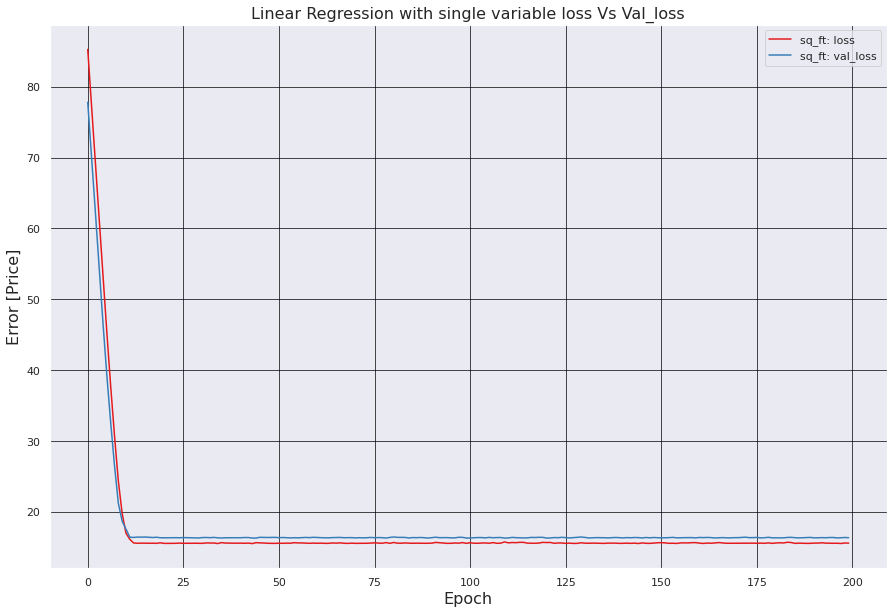

In [47]:
def plot_loss(history):
  plt.figure(figsize=(15,10))
  sns.set(palette='Set1')

  plt.plot(history_sq_ft.history['loss'], label='sq_ft: loss ')
  plt.plot(history_sq_ft.history['val_loss'], label='sq_ft: val_loss')

  plt.title("Linear Regression with single variable loss Vs Val_loss", fontsize=16)
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Error [Price]", fontsize=16)
  plt.legend(loc="upper right")

  plt.grid(color='black', linestyle='-', linewidth=0.7)
plot_loss(history_sq_ft)

{'house_price_linear_model_sqft': 12.000872611999512}


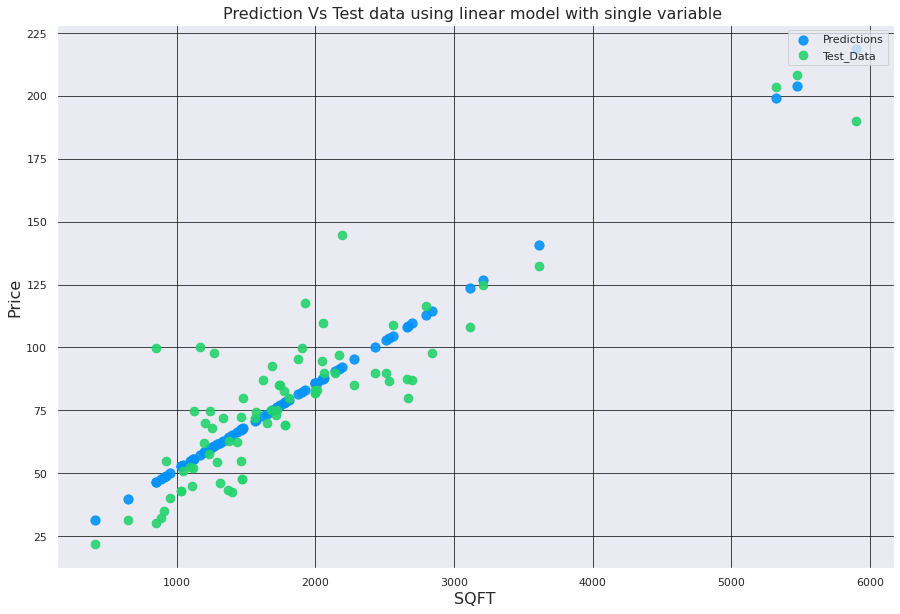

In [48]:
test_results = {}
test_results['house_price_linear_model_sqft'] = house_price_linear_model_sqft.evaluate(
    df_test['sqft'],
    test_labels,verbose=0)

#print ("\n Errors in test data\n")
print (test_results)
list_price_predict = house_price_linear_model_sqft.predict(df_test['sqft'])

def plot_predict_house(x, y):
  plt.figure(figsize=(15,10))
  sns.set(palette='terrain')

  #plt.scatter(df_train ['sqft'], train_labels, label='Data')
  plt.scatter(x, y, label='Predictions', s=85,alpha=0.9)
  plt.scatter(x, test_labels, label='Test_Data', s=75,alpha=0.9)
  plt.title("Prediction Vs Test data using linear model with single variable ", fontsize=16)

  plt.xlabel("SQFT", fontsize=16)
  plt.ylabel("Price", fontsize=16)
  plt.legend(loc="upper right")
  plt.grid(color='black', linestyle='-', linewidth=0.7)

plot_predict_house(df_test['sqft'],list_price_predict)

=> Used test set for predictions. 

=> For predicted price,we observe a positive relationship between the house price and sqft. 

## Linear Regression(Multiple Variables)

In [49]:
print(data_normalizer.mean.numpy())

[   3.358    2.893 1984.616    0.182    0.068    0.212    0.303    0.111
    0.124]


- Building the sequential model

In [50]:
house_price_linear_model2 = tf.keras.Sequential([
    data_normalizer,
    layers.Dense(units=1)
])

In [51]:
house_price_linear_model2.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.341],
       [-0.582],
       [ 0.019],
       [ 0.051],
       [-0.601],
       [-0.454],
       [-0.305],
       [ 0.309],
       [ 0.505]], dtype=float32)>

In [52]:
print (house_price_linear_model2.summary())


house_price_linear_model2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=.1),
    #loss="mse", metrics=["mae"])
    loss='mean_absolute_error')

history2 = house_price_linear_model2.fit(
    df_train, train_labels,
   # df_train, train_labels,
    epochs=200,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________
None


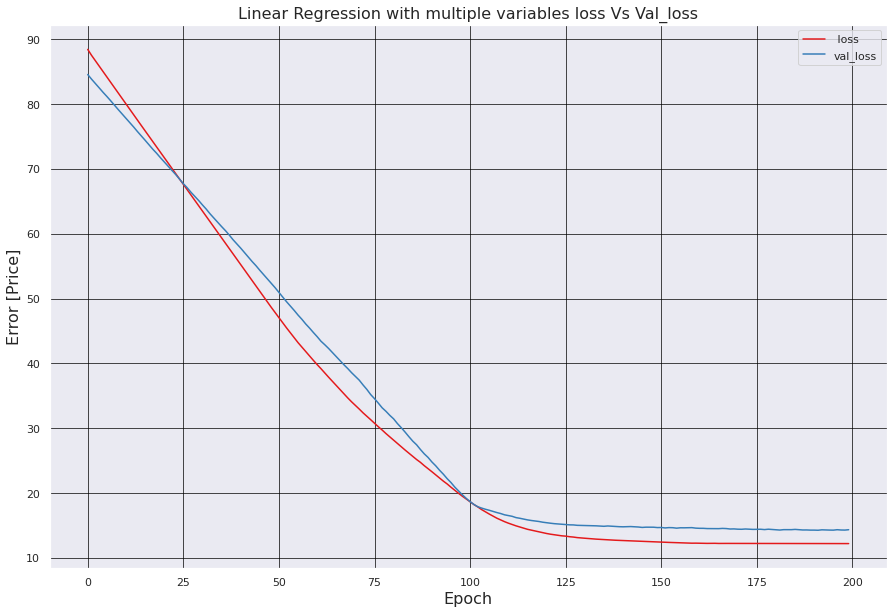

In [53]:
def plot_loss(history2):
  plt.figure(figsize=(15,10))
  sns.set(palette='Set1')
  plt.plot(history2.history['loss'], label=' loss ')
  plt.plot(history2.history['val_loss'], label='val_loss')
  
  plt.title("Linear Regression with multiple variables loss Vs Val_loss", fontsize=16)
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Error [Price]", fontsize=16)
  plt.legend(loc="upper right")
 
  plt.grid(color='black', linestyle='-', linewidth=0.7)
plot_loss(history2)

In [54]:

test_results['house_price_linear_model2'] = house_price_linear_model2.evaluate(
    df_test, test_labels,verbose=0)

print ("\n *** error in test data *** \n")
print (test_results)


 *** error in test data *** 

{'house_price_linear_model_sqft': 12.000872611999512, 'house_price_linear_model2': 10.533699035644531}


## DNN Regression(Single Variable)

DNN model contains few more layers compared to the linear model. 
* The normalization layer
*Two hidden, nonlinear, dense layers using the relu nonlinearity
*A linear single-output layer.

In [55]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [56]:
dnn_house_price_model = build_and_compile_model(data_normalizer_sqft)
dnn_house_price_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


- Training the model

In [57]:
%%time
history_dnn = dnn_house_price_model.fit(
    df_train['sqft'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.85 s, sys: 223 ms, total: 8.07 s
Wall time: 7.71 s


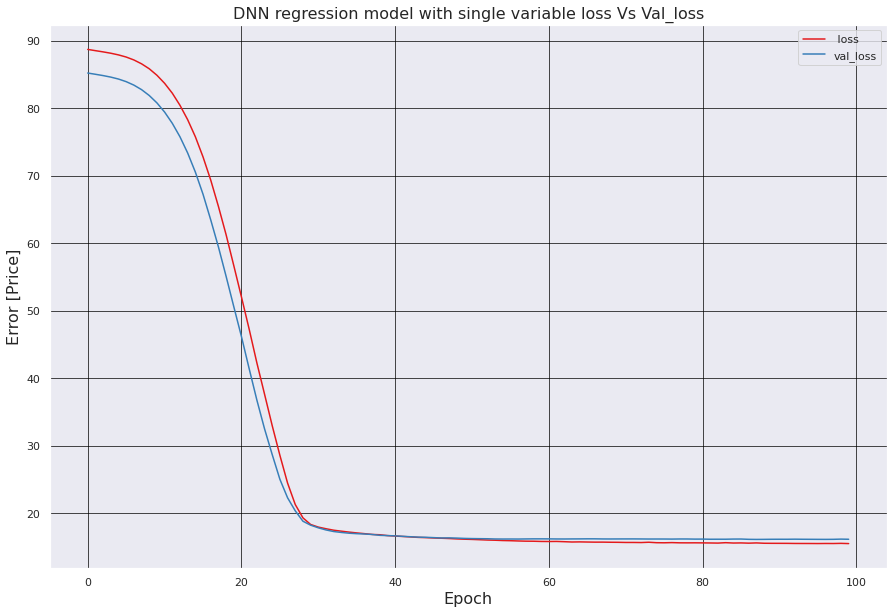

In [58]:
def plot_loss(history_dnn):
  plt.figure(figsize=(15,10))
  sns.set(palette='Set1')
  plt.plot(history_dnn.history['loss'], label=' loss ')
  plt.plot(history_dnn.history['val_loss'], label='val_loss')
  
  plt.title("DNN regression model with single variable loss Vs Val_loss", fontsize=16)
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Error [Price]", fontsize=16)
  plt.legend(loc="upper right")
 
  plt.grid(color='black', linestyle='-', linewidth=0.7)
plot_loss(history_dnn)


 *** error in test data *** 

{'house_price_linear_model_sqft': 12.000872611999512, 'house_price_linear_model2': 10.533699035644531, 'dnn_house_price_model': 12.104996681213379}


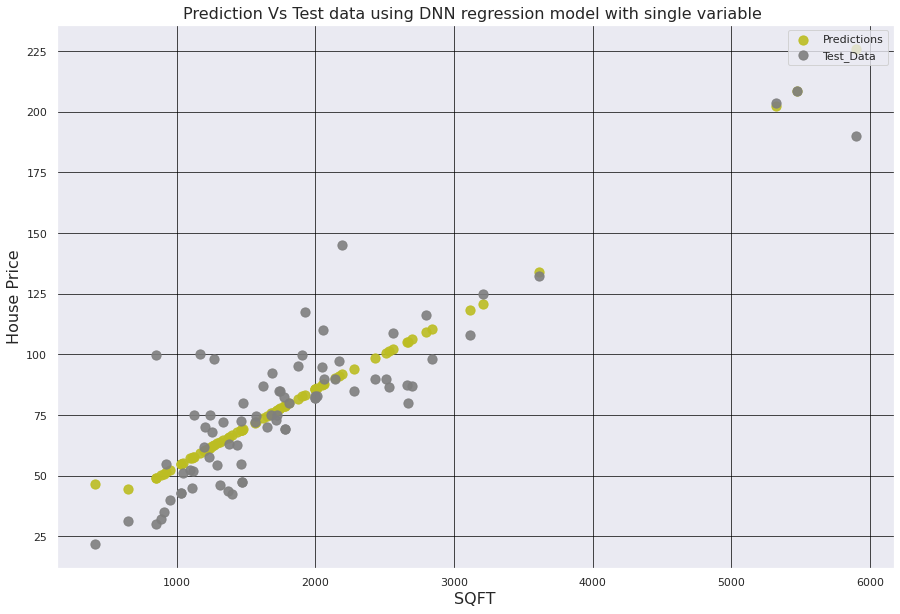

In [59]:
test_results['dnn_house_price_model'] = dnn_house_price_model.evaluate(
     df_test['sqft'], test_labels,
    verbose=0)

print ("\n *** error in test data *** \n")
print (test_results)

list_price_predict = dnn_house_price_model.predict(df_test['sqft'])
def plot_predict_house(x, y):
  plt.figure(figsize=(15,10))
  sns.set(palette='tab10_r')

  #plt.scatter(df_train ['sqft'], train_labels, label='Data')
  plt.scatter(x, y, label='Predictions', s=85,alpha=0.9)
  plt.scatter(x, test_labels, label='Test_Data', s=85,alpha=0.9)
  plt.title("Prediction Vs Test data using DNN regression model with single variable ", fontsize=16)
  plt.xlabel('SQFT', fontsize=16)
  plt.ylabel("House Price", fontsize=16)
  plt.legend(loc="upper right")
  plt.grid(color='black', linestyle='-', linewidth=0.7)

plot_predict_house(df_test['sqft'],list_price_predict)

## DNN Regression(Multiple Variables)

In [60]:
dnn_house_price_model2 = build_and_compile_model(data_normalizer)
dnn_house_price_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


- Training the model

In [61]:
%%time
history_dnn2 = dnn_house_price_model2.fit(
    df_train, train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 15.8 s, sys: 429 ms, total: 16.2 s
Wall time: 15.4 s


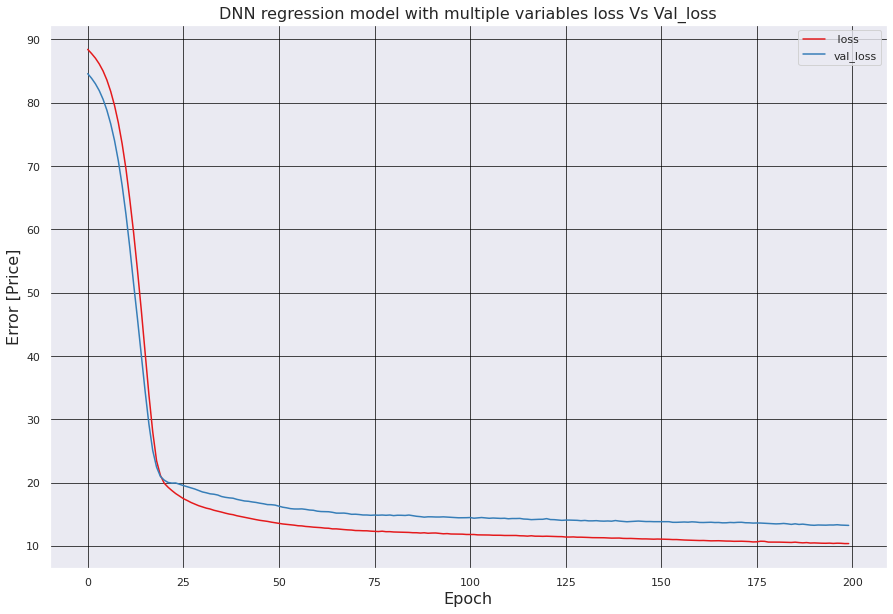

In [62]:
def plot_loss(history_dnn2):
  plt.figure(figsize=(15,10))
  sns.set(palette='Set1')
  plt.plot(history_dnn2.history['loss'], label=' loss ')
  plt.plot(history_dnn2.history['val_loss'], label='val_loss')
  
  plt.title("DNN regression model with multiple variables loss Vs Val_loss", fontsize=16)
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Error [Price]", fontsize=16)
  plt.legend(loc="upper right")
 
  plt.grid(color='black', linestyle='-', linewidth=0.7)
plot_loss(history_dnn2)

In [63]:
test_results['dnn_house_price_model2'] = dnn_house_price_model2.evaluate(
     df_test, test_labels,
    verbose=0)

print ("\n * error in test data * \n")
print (test_results)


 * error in test data * 

{'house_price_linear_model_sqft': 12.000872611999512, 'house_price_linear_model2': 10.533699035644531, 'dnn_house_price_model': 12.104996681213379, 'dnn_house_price_model2': 11.693113327026367}


In [64]:
pd.DataFrame(test_results, index=['Mean absolute error']).T

,Mean absolute error
house_price_linear_model_sqft,12.000873
house_price_linear_model2,10.533699
dnn_house_price_model,12.104997
dnn_house_price_model2,11.693113


The 4 models implemented are:
* Linear regression (Single variable)
* Linear regression (Multiple variables)
*DNN regression (Single variable)
* DNN regression(Multiple variables)

=> Calculated mean absolute error (MAE) for each model, compared the models and found the model that has lowest MAE. (DNN for multiple variables, dnn_house_price_model2 has the lowest MAE) 

=> Hence, used dnn_house_price_model2 for price prediction and house recommendation.

# **Prediction Model**
- Created a dummy csv file including zip,beds,baths,	and sqft for six different zipcodes.

- Implemented price prediction using best performaing model.

- Arranged the data for house price prediction

In [65]:
df_predict.columns

Index(['zip', 'beds', 'baths', 'sqft'], dtype='object')

In [66]:
#Created the dummy variables for six zipcodes
dummy=pd.get_dummies(df_predict['zip'])

#Concated the dummy variables to main file
df_predict=pd.concat([df_predict,dummy],axis=1)

#After creating dummy variables, we dropped the Zip column.
df_predict = df_predict.drop(columns = ['zip'], axis = 1)


In [67]:
df_predict.head()

,beds,baths,sqft,90042,91325,91326,91329,91331,91335
0,3,2.0,1471,1,0,0,0,0,0
1,2,2.0,1096,1,0,0,0,0,0
2,2,2.0,1214,1,0,0,0,0,0
3,1,1.0,673,1,0,0,0,0,0
4,2,1.0,720,1,0,0,0,0,0


## Performing Prediction using the best performance model "DNN Regression multiple variable"

In [68]:
X_dummy = df_predict
y_dummy_pred = dnn_house_price_model2.predict(X_dummy)

- Displaying the data with the predicted house prices in (10k)

In [69]:
#Displaying predicted house prices
prediction_dummy_df = pd.DataFrame(dnn_house_price_model2.predict(X_dummy), columns = {'Predicted_List_Price (x10K)'}).set_index([pd.Index(X_dummy.index)])
all_dummy_df = X_dummy.join(prediction_dummy_df)
all_dummy_df

,beds,baths,sqft,90042,91325,91326,91329,91331,91335,Predicted_List_Price (x10K)
0,3,2.0,1471,1,0,0,0,0,0,91.653885
1,2,2.0,1096,1,0,0,0,0,0,78.369011
2,2,2.0,1214,1,0,0,0,0,0,81.462265
3,1,1.0,673,1,0,0,0,0,0,63.204899
4,2,1.0,720,1,0,0,0,0,0,67.561722
5,2,3.0,1370,1,0,0,0,0,0,90.234131
6,4,3.0,1968,1,0,0,0,0,0,114.128693
7,2,1.0,924,1,0,0,0,0,0,73.120552
8,3,1.0,951,1,0,0,0,0,0,76.981995
9,2,3.0,1682,1,0,0,0,0,0,99.992676


In [70]:
all_dummy_df.columns

Index(['beds', 'baths', 'sqft', 90042, 91325, 91326, 91329, 91331, 91335, 'Predicted_List_Price (x10K)'], dtype='object')

In [71]:
final_predict = all_dummy_df.drop(columns = ['beds', 'baths', 'sqft', 90042, 91325, 91326, 91329, 91331, 91335,], axis = 1)

In [72]:
final_predict.head()

,Predicted_List_Price (x10K)
0,91.653885
1,78.369011
2,81.462265
3,63.204899
4,67.561722


# Arranging data for Zillow App

In [73]:
#Created dataframe and stored result_set
result = pd.DataFrame(result_set)

In [74]:
#Defining column names for created dataframe

result.columns = ['id','worker_id', 'Listed_Price', 'Address','Zipcode','Bedrooms','Bathrooms','SQFT','Status','Link']

In [75]:
#defining column names 

df_new1_for_insertion.columns = ['Description','Zestimate','Image']

In [76]:
#First csv
result.to_csv('Home.csv')

In [77]:
#Second file
df_new1_for_insertion.to_csv('SecondHome.csv')

In [78]:
#Third file
final_predict.to_csv('Prediction.csv')

In [79]:
#reading all csv files 
data1 = pd.read_csv('/content/Home.csv') 
data2 = pd.read_csv('/content/SecondHome.csv') 
data3 = pd.read_csv('/content/Prediction.csv')

# using merge function by setting how='inner' 
combined_df = pd.merge(data1, data2) 
ZillowData = pd.merge(combined_df,data3)

#displaying result 
#print(combined_df) 

In [80]:
ZillowData.to_csv('Zillow.csv')

#EDA for predicted house price

In [81]:
df_eda = pd.DataFrame()
df_eda = ZillowData.copy()

In [82]:
df_eda['Listed_Price'] = df_eda['Listed_Price']/(10000)
df_eda['Zestimate'] = df_eda['Zestimate']/(10000)

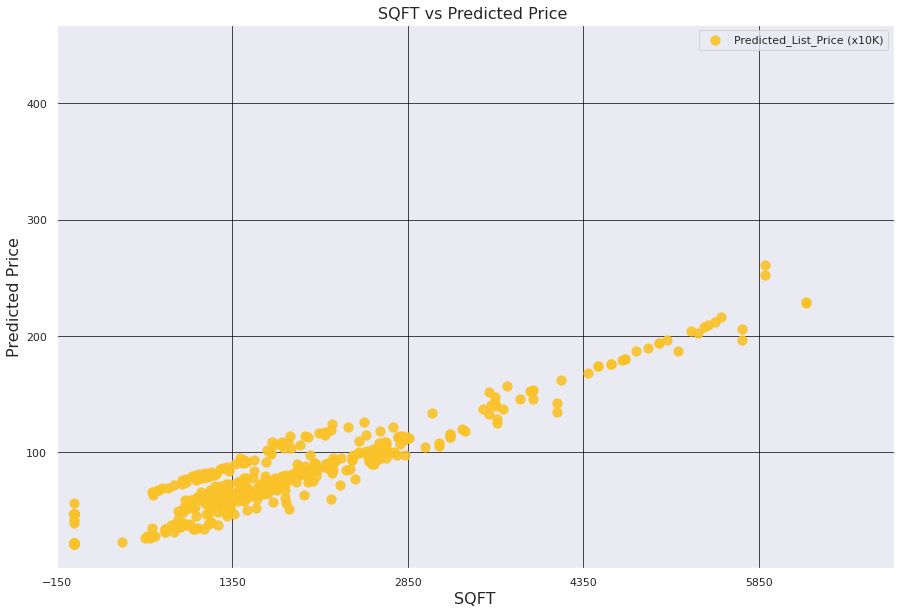

In [85]:
#SQFT Vs Predicted Price
plt.figure(figsize=(15,10))
sns.set(palette='inferno_r')

plt.scatter(x = 'SQFT', y = 'Predicted_List_Price (x10K)', s=85,alpha=0.9, data = df_eda)

plt.xlim([-150,7000])
plt.xticks(np.arange(-150, 7000, 1500))
plt.title("SQFT vs Predicted Price ", fontsize=16)
plt.xlabel('SQFT', fontsize=16)
plt.ylabel("Predicted Price", fontsize=16)
plt.legend(loc="upper right")
plt.grid(color='black', linestyle='-', linewidth=0.7)

- The above graph represents square feet versus predicted price(x10k) with positive correlation. As square feet increases, the predicted price is also increasing.

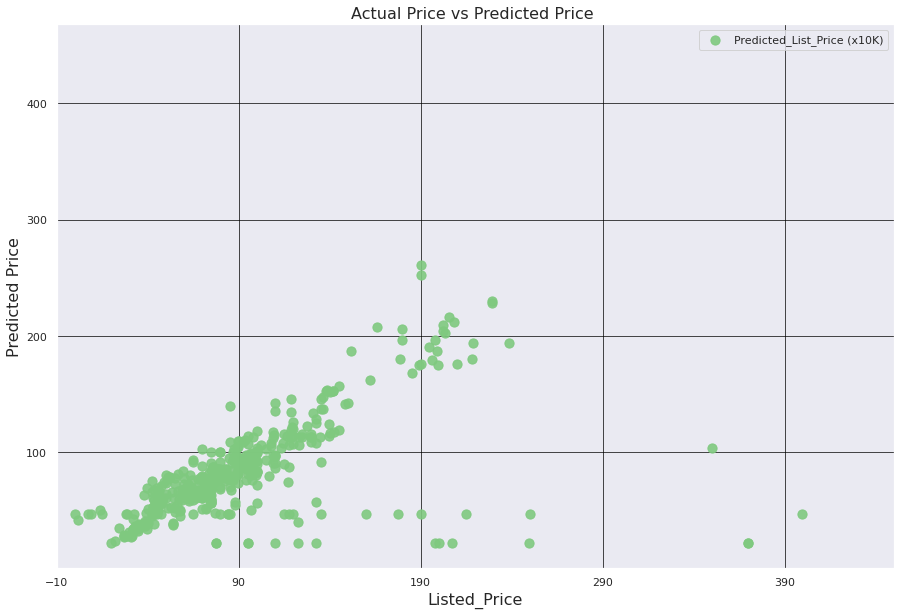

In [88]:
# Actual Price vs Predicted Price 
plt.figure(figsize=(15,10))
sns.set(palette='Accent')

plt.scatter(x = 'Listed_Price', y = 'Predicted_List_Price (x10K)', s=85,alpha=0.9, data = df_eda)

plt.xlim([-10,450])
plt.xticks(np.arange(-10, 450, 100))
plt.title("Actual Price vs Predicted Price ", fontsize=16)
plt.xlabel('Listed_Price', fontsize=16)
plt.ylabel("Predicted Price", fontsize=16)
plt.legend(loc="upper right")
plt.grid(color='black', linestyle='-', linewidth=0.7)

- The above graph represents actual listed price versus predicted price in (x10k). 

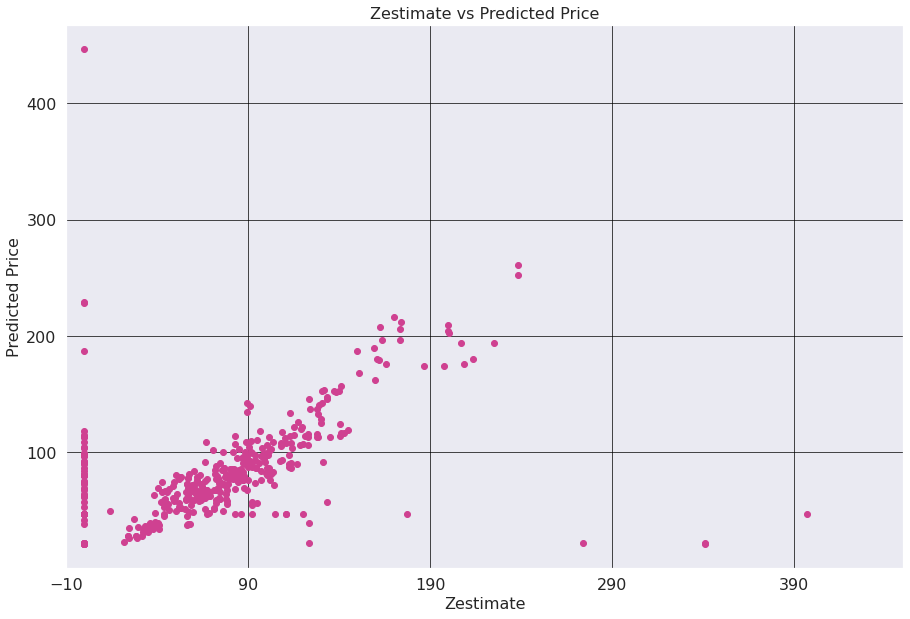

In [89]:
# Zestimate vs Predicted Price 

plt.figure(figsize=(15,10))
sns.set(palette='PiYG')

plt.scatter(x = 'Zestimate', y = 'Predicted_List_Price (x10K)', data = df_eda)

plt.xlim([-10,450])
plt.xticks(np.arange(-10, 450, 100))
plt.title('Zestimate vs Predicted Price',fontsize=16)
plt.xlabel('Zestimate',fontsize=16)
plt.ylabel('Predicted Price', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='black', linestyle='-', linewidth=0.7)
plt.show()


- The above graph represents Z-estimate versus predicted price.

# Customized User input 

- To create a comparision for six zipcodes w.r.t their price prediction, implemented the for loop to iterate the values.



In [90]:
# Defining required columns and showing the price prediction for the specific requirements.
def price_predict_ip_param(ip_beds,ip_baths,ip_sqft ):
  ip_zip =  [  90042,  91325,  91326,  91329,  91331,  91335 ]
  data = [[ip_beds, ip_baths  , ip_sqft, 0, 0 , 0 , 0 , 0, 0 ]]
  ip_df = pd.DataFrame(data, columns = ['beds' , 'baths', 'sqft', 
                                        90042,  91325,  91326 , 91329,  91331,  91335]) 

  # Iterating the range with length of the given zipcodes
  for i in range(len(ip_zip)+1):
    if i >0:
      ip_df.loc[len(ip_df.index)] = ip_df.iloc[0]
      ip_df.loc[i][ip_zip[i-1]] =  1 
  ip_df = ip_df.drop([0])

  # Prediction using DNN Regression model
  ip_df['predicted_price(x10k)'] =  dnn_house_price_model2.predict(ip_df)
  return (ip_df)

- Price prediction for customized user input data

In [91]:
#User prompt to enter the requirements based on number of bedrooms, bathrooms and squarefeet
ip_beds  = input ("Enter a number of Beds: ")
ip_baths = input ("Enter a number of Baths: ")
ip_sqft  = input ("Enter a number of sqft: ")

result =  price_predict_ip_param(int(ip_beds),int(ip_baths),int(ip_sqft))

# Prints in the console the variable as requested
print (result)

#Showing the minimum price prediction value
res_min = min(result['predicted_price(x10k)'],key=lambda x:float(x)) 

Enter a number of Beds: 2
Enter a number of Baths: 2
Enter a number of sqft: 5434
   beds  baths  sqft  90042  91325  91326  91329  91331  91335  predicted_price(x10k)
1     2      2  5434      1      0      0      0      0      0             217.400421
2     2      2  5434      0      1      0      0      0      0             182.800888
3     2      2  5434      0      0      1      0      0      0             204.316559
4     2      2  5434      0      0      0      1      0      0             190.362701
5     2      2  5434      0      0      0      0      1      0             151.819504
6     2      2  5434      0      0      0      0      0      1             183.099518


- **Best recommended price** among the six zipcodes

In [92]:
print("For the given user input data:")
print("Bedrooms : " +ip_beds+ "  Bathroom's : " +ip_baths+ "  SQFT : " +ip_sqft)
print("The best recommended price is $" +str(res_min))

For the given user input data:
Bedrooms : 2  Bathroom's : 2  SQFT : 5434
The best recommended price is $151.8195037841797


- We can see the best recommended price with zipcode

In [93]:
result_min = result[ result['predicted_price(x10k)'] == result['predicted_price(x10k)'].min()]
result_min= result_min.loc[:, (result_min != 0).any(axis=0)]
result_min 

,beds,baths,sqft,91331,predicted_price(x10k)
5,2,2,5434,1,151.819504


By using the best performance model, Deep neural network(DNN) we predicted the price for dummy variables file. 

*   In the file, we generated different ranges of data from minimum to maximum bedrooms,bathrooms and squarefoot as input and based on the inputs we created a column "Prediction" to show the predicted price.

*   We compared the price prediction for different zipcodes using the user prompt and fetched the price for the  given inputs,

*   Atlast, we recommended the best minimum price in(10k) house with the given requirements(bedrooms,bathrooms and squarefoot) along with the zipcode.


*   For Instance, User prompt entered the requirements as number of bedrooms:2, bathrooms:2 nd squarefoot as:2569 then the table will show the comparision of predicted price for six different zipcodes. Out of the six prices, it will give you a minimum valued price $923977 with related zipcode:91331.








## Clean-up function

- Created the clean-up function that can be used to drop all tables such that code can run from beginning to end without issue

In [187]:
def refresh_database_environment():
  cnx = establish_database_connection()
  query = "DROP TABLE IF EXISTS house_details_results_preliminary;"
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()
  cursor.close()
  cnx.close()

  cnx = establish_database_connection()
  query = "DROP TABLE IF EXISTS house_details_workers;"
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()
  cursor.close()
  cnx.close()  

  cnx = establish_database_connection()
  query = "DROP TABLE IF EXISTS house_details_results_work;"
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()
  cursor.close()
  cnx.close()  

  cnx = establish_database_connection()
  query = "DROP TABLE IF EXISTS new_page_house_description;"
  cursor = cnx.cursor()
  cursor.execute(query)
  cnx.commit()
  cursor.close()
  cnx.close()  
  return

In [188]:
#calling clean-up function
refresh_database_environment() 

# **Conclusion:**

* Implemented Web scraping from Zillow website using Beautiful Soup and stored the data in MySQL database after removing HTML tags.


* Fetched the data for house price description, zestimate and image url.


* Implemented four different models for house price prediction using TensorFlow and found DNN regression with multiple variables to be the best model based on MAE.

* The built model can predict the house prices for the six mentioned zip codes and eventually recommend the lowest price amongst the predicted prices as the best recommended price for the customized user input.


* The scraped data is being used to develop the zillow app where users can have access to the houses which are for sale. The app will display few  filters such as  number of bedrooms, bathrooms and choose the status of the house on the basis of user preference. The option to save the favorite houses is only accessible to the signed up users.


* Each house displays the details such as actual price, zillow’s estimated price, predicted price and price difference between actual and predicted price (using the best performing model).  



## **References:**

[1] Zillow houses- https://www.zillow.com/

[2] House Price prediction- https://towardsdatascience.com/simple-house-price-predictor-using-ml-through-tensorflow-in-python-cbd2b637904b

[3]Web Scraping using beautiful soup- https://www.scrapingbee.com/blog/web-scraping-101-with-python/

[4]Tensor flow Regression Models-https://www.tensorflow.org/tutorials/keras/regression


